In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
from scipy.stats import f_oneway, chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")
%matplotlib inline

#import warnings
#warnings.filterwarnings("ignore")


In [3]:
#read the data 
df = pd.read_csv('youtube_analysis.csv',encoding='cp1252') 

In [4]:
df

,Video Views,Video Title,Creator Gender,Total Channel Subcribers,Total Chanel Views,Duration in Seconds,No of Likes,Language of the Video,Subtitle,Video Description,Hashtags,No of Comments,No of Videos the Channel
0,"146,059",Samse - Didupe Off-road Royal Enfield Himalayan,Male,40200,7964284,"1,841.00",6700.0,Kannada,No,Yes,0,419,462
1,"231,969",Bhoom Baddhal Web Series,Male,920000,137535681,864,7800.0,Telugu,No,Yes,1,189,251
2,878,"Customer Psychology, Four Views Of Consumer De...",Female,458,72945,492,858.0,Hindi,No,Yes,0,0,158
3,"9,965",Top countries with proven natural gas reserves,NaN,1680000,541653219,66,188.0,English,No,Yes,0,77,46509
4,"39,780,561",73 Questions With Selena Gomez,NaN,12100000,3600496171,460,901000.0,English,Yes,Yes,0,28221,2872
...,...,...,...,...,...,...,...,...,...,...,...,...,...
900,"6,892",Calming mashup of Islamic Nasheed 2022 | Isami...,NaN,594000,129926690,827,235.0,Urdu + Arabic,No,Yes,0,15,5024
901,"16,554",Amchi Nawayat Mehfil hee,NaN,594000,129926690,404,117.0,Nawayathi,No,Yes,2,0,5024
902,"32,798",Aas ge Kaagaz,NaN,23500,5104872,384,1.0,Nawayathi,No,Yes,3,0,1018
903,"1,503",Anjuman Tarana by ABHS Students | Anjuman Anju...,NaN,23500,5104872,279,1.0,Urdu,No,Yes,3,0,1018


**Data Cleaning**

In [5]:
df.dtypes

Video Views                  object
Video Title                  object
Creator Gender               object
Total Channel Subcribers     object
Total Chanel Views           object
Duration in Seconds          object
No of Likes                 float64
Language of the Video        object
Subtitle                     object
Video Description            object
Hashtags                      int64
No of Comments               object
No of Videos the Channel      int64
dtype: object

In [6]:
#change column name
df.rename( columns={'Video Views':'views', 'Video Title': 'title', 'Creator Gender':'gender',
                   'Total Channel Subcribers': 'subscribers', 'Total Chanel Views':'totalviews',
                   'Duration in Seconds':'duration','No of Likes':'likes', 'Language of the Video':'language', 
                   'Subtitle':'subtitle', 'Video Description':'description', 'Hashtags':'hashtags',
                    'No of Comments': 'comments', 'No of Videos the Channel':'totalvideo'},
            inplace=True,
)

In [7]:
language = [] 
for i in df['language']: 
    if i not in language and i != None: 
        language.append(i) 

print(language)
print(len(language))

['Kannada', 'Telugu', 'Hindi', 'English', 'Japenese', 'Tamil', nan, 'Urdu', 'Punjabi', 'Malayalam', 'Mongalian', 'Russian', 'Italian', 'Hindi/English', 'Sanskrit', 'English + Hindi', 'Konkani', 'Arabic', 'Urdu + Arabic', 'Nawayathi']
20


In [8]:
#Convert Categorial Data into Numerical Data (Gender, Subtitle, Video Description)
df['gender'].replace(['Female', 'Male','Company'],
                          [0, 1, 2], inplace = True)
df['description'].replace(['No', 'Yes'],
                            [0, 1], inplace = True)
df['subtitle'].replace(['No', 'Yes'],
                        [0, 1], inplace = True)
df['language'].replace(['Kannada', 'Telugu', 'Hindi', 'English', 'Japenese', 'Tamil', 'Urdu', 'Punjabi', 'Malayalam', 'Mongalian', 'Russian', 'Italian', 'Hindi/English', 'Sanskrit', 'English + Hindi', 'Konkani', 'Arabic', 'Urdu + Arabic', 'Nawayathi'],
                        [0, 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18], inplace=True)

In [9]:
#turn title to number of words in the title 
for i in df['title']: 
    length = len(i.split())
    df['title'] = df['title'].replace(i, length)

In [10]:
#turn all data to int64 (except subtitle,decription, hashtags boolean)
#views, duration have comma, delete it
for i in df['views']: 
    new_views = i.replace(',', '')
    df['views'] = df['views'].replace(i, new_views)
    
for i in df['duration']: 
    new_duration = i.replace(',', '')
    df['duration'] = df['duration'].replace(i, new_duration)
    
for i in df['totalviews']: 
    new_totalviews = i.replace(',', '')
    df['totalviews'] = df['totalviews'].replace(i, new_totalviews)
    
for i in df['comments']: 
    new_comments = i.replace(',', '')
    df['comments'] = df['comments'].replace(i, new_comments)

In [11]:
#no. of null value 
df.isna().sum()

views            0
title            0
gender         314
subscribers      0
totalviews       0
duration         0
likes            1
language        21
subtitle         1
description      0
hashtags         0
comments         0
totalvideo       0
dtype: int64

In [12]:
#replace null value in gender = 2 (Company) since most of them are companies 
df['gender'] = df['gender'].replace(np.nan, 2)

In [13]:
#drop the rows with missing value in likes, language and subtitle
df = df.dropna(subset=['likes', 'language','subtitle'])

In [14]:
df.isna().sum()

views          0
title          0
gender         0
subscribers    0
totalviews     0
duration       0
likes          0
language       0
subtitle       0
description    0
hashtags       0
comments       0
totalvideo     0
dtype: int64

In [15]:
#since all the data are in integer -> convert to int for easy reading 
df = df.astype({'gender':'int','likes':'int','language':'int','subtitle':'int',
               'views':'int','subscribers':'int','likes':'int', 'comments':'int'})

In [16]:
#totalviews consist of number with E11 -> need to convert to float then to int 
df = df.astype({'totalviews':'float'})
df = df.astype({'totalviews':'int'})

In [17]:
df = df.astype({'duration':'float'})
df = df.astype({'duration':'int'})

In [18]:
df.dtypes

views          int64
title          int64
gender         int64
subscribers    int64
totalviews     int64
duration       int64
likes          int64
language       int64
subtitle       int64
description    int64
hashtags       int64
comments       int64
totalvideo     int64
dtype: object

In [19]:
df.describe()

,views,title,gender,subscribers,totalviews,duration,likes,language,subtitle,description,hashtags,comments,totalvideo
count,8.820000e+02,882.000000,882.000000,8.820000e+02,8.820000e+02,882.000000,8.820000e+02,882.000000,882.000000,882.000000,882.000000,8.820000e+02,882.000000
mean,5.519602e+07,9.223356,1.275510,1.044594e+07,2.267447e+09,1965.382086,5.906553e+05,3.170068,0.587302,0.947846,1.026077,4.648623e+04,5080.191610
std,4.052034e+08,4.234473,0.613924,2.418792e+07,1.062494e+10,6474.125940,2.993197e+06,2.070957,0.492599,0.222464,1.838669,4.848507e+05,24495.324106
min,2.300000e+01,1.000000,0.000000,3.400000e+01,3.600000e+01,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000
25%,1.969068e+05,6.000000,1.000000,3.477500e+05,3.684144e+07,320.250000,5.300000e+03,2.000000,0.000000,1.000000,0.000000,2.235000e+02,157.000000
50%,1.265499e+06,9.000000,1.000000,2.190000e+06,2.661097e+08,651.500000,3.181650e+04,3.000000,1.000000,1.000000,0.000000,1.212000e+03,415.500000
75%,9.142648e+06,12.000000,2.000000,9.330000e+06,1.267778e+09,1044.000000,1.855000e+05,3.000000,1.000000,1.000000,1.000000,7.032500e+03,1438.000000
max,7.990990e+09,26.000000,2.000000,3.052000e+08,2.020000e+11,62700.000000,4.900000e+07,18.000000,1.000000,1.000000,28.000000,1.124480e+07,420000.000000


In [20]:
df['views'].quantile(0.75)

9142648.25

In [21]:
popular = [] 

for i in df['views']: 
    if (i >= 9142648.25): 
        popular.append(1)
    else: 
        popular.append(0)

In [22]:
df['popular'] = popular

<AxesSubplot:>

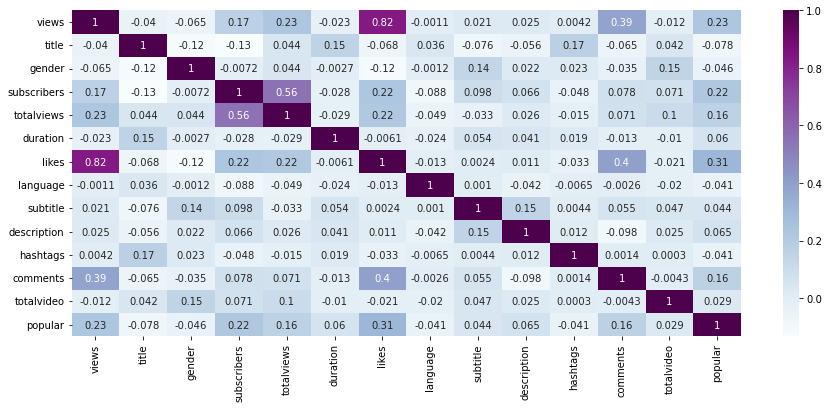

In [23]:
corr = df.corr()
plt.figure(figsize=(15,6))
sns.heatmap(corr, annot = True, cmap="BuPu")

<AxesSubplot:ylabel='gender'>

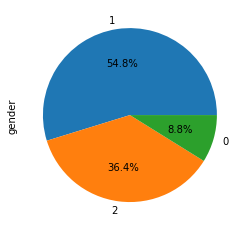

In [36]:
df['gender'].value_counts(dropna = False).plot(kind = 'pie',autopct='%1.1f%%')

<AxesSubplot:ylabel='subtitle'>

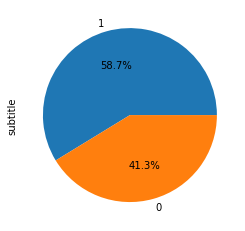

In [40]:
df['subtitle'].value_counts(dropna = False).plot(kind = 'pie',autopct='%1.1f%%')

<AxesSubplot:ylabel='description'>

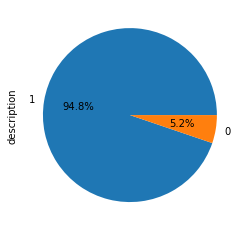

In [41]:
df['description'].value_counts(dropna = False).plot(kind = 'pie',autopct='%1.1f%%')

<AxesSubplot:ylabel='language'>

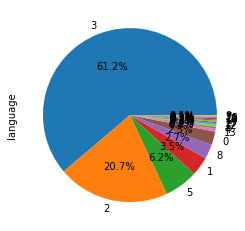

In [45]:
df['language'].value_counts(dropna = False).plot(kind = 'pie',autopct='%1.1f%%')

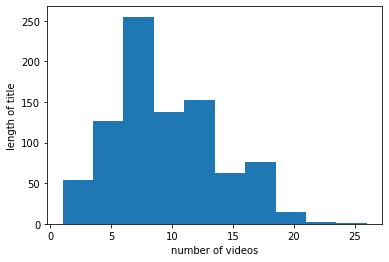

In [32]:
plt.hist(df['title'])
plt.ticklabel_format(style='plain')  
plt.xlabel('number of videos')
plt.ylabel('length of title')
plt.show()

**Pre-Proccessing**


In [23]:
def AOV() :
    numcol = [ ]
    for i in ['title','subscribers','totalviews',
              'duration','likes','hashtags','comments','totalvideo']: 
        pval = f_oneway (*df.groupby('popular')[i].apply(list))
        if (pval[1] < 0.05):
            print(i,':p−value= ', pval[1])
            numcol.append(i)
        else:
            print(i, ': p−value= ', pval[1])

AOV()
# > 0.05 is not related
# duration, hashtags, totalvideo no need

title :p−value=  0.020323587267428167
subscribers :p−value=  7.616734318076515e-11
totalviews :p−value=  2.9509607939023274e-06
duration : p−value=  0.07579496025777993
likes :p−value=  1.5987026896997094e-21
hashtags : p−value=  0.2243612101139017
comments :p−value=  2.0352096247969472e-06
totalvideo : p−value=  0.3918369287856843


In [24]:
def chi(): 
    catcol = [] 
    for i in ['gender', 'language', 'subtitle', 'description']: 
        pval = chi2_contingency(pd.crosstab(df['popular'], df[i]))
        if (pval[1] < 0.05):
            print(i,':p−value= ', pval[1])
            catcol.append(i)
        else:
            print(i, ': p−value= ', pval[1])

chi()

#gender, subtitle, description no need 

gender : p−value=  0.3855868667416354
language :p−value=  5.274770392025818e-05
subtitle : p−value=  0.22387234927704225
description : p−value=  0.07899965699850255


In [25]:
#drop unnecessary column 
df = df.drop(['views','duration', 'hashtags','totalvideo','gender','subtitle', 'description'], axis=1)

<AxesSubplot:>

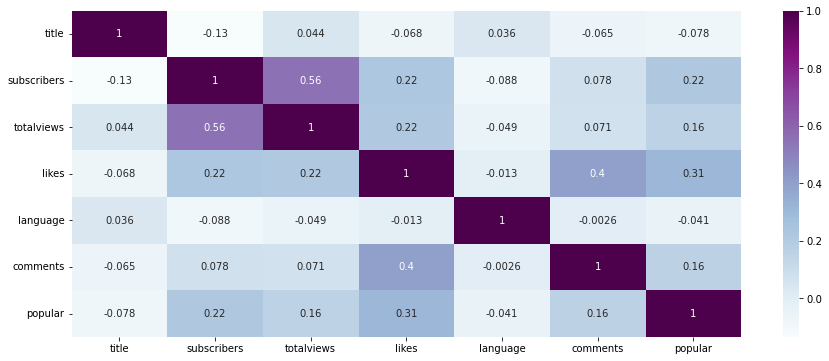

In [26]:
corr=df.corr() # gives us the correlation values
plt.figure(figsize=(15,6))
sns.heatmap(corr, annot = True, cmap="BuPu") # let's visualise the correlation ma plt.show()

**Exploratory Data Analysis**

In [27]:
df.describe()

,title,subscribers,totalviews,likes,language,comments,popular
count,882.000000,8.820000e+02,8.820000e+02,8.820000e+02,882.000000,8.820000e+02,882.000000
mean,9.223356,1.044594e+07,2.267447e+09,5.906553e+05,3.170068,4.648623e+04,0.250567
std,4.234473,2.418792e+07,1.062494e+10,2.993197e+06,2.070957,4.848507e+05,0.433585
min,1.000000,3.400000e+01,3.600000e+01,0.000000e+00,0.000000,0.000000e+00,0.000000
25%,6.000000,3.477500e+05,3.684144e+07,5.300000e+03,2.000000,2.235000e+02,0.000000
50%,9.000000,2.190000e+06,2.661097e+08,3.181650e+04,3.000000,1.212000e+03,0.000000
75%,12.000000,9.330000e+06,1.267778e+09,1.855000e+05,3.000000,7.032500e+03,0.750000
max,26.000000,3.052000e+08,2.020000e+11,4.900000e+07,18.000000,1.124480e+07,1.000000


In [28]:
mean = df.groupby('popular')['likes', 'subscribers','comments'].mean().round()
print(mean)
meandf = pd.DataFrame({'variables': ['likes', 'subscribers','comments','likes','subscribers', 'comments'],
                   'mean': [48942.0, 7415069.0, 1896.0, 2210894.0, 19511136.0 ,179855.0],
                   'popular': [0,0,0,1,1,1]})

             likes  subscribers  comments
popular                                  
0          48942.0    7415069.0    1896.0
1        2210894.0   19511136.0  179855.0


<AxesSubplot:xlabel='variables', ylabel='mean'>

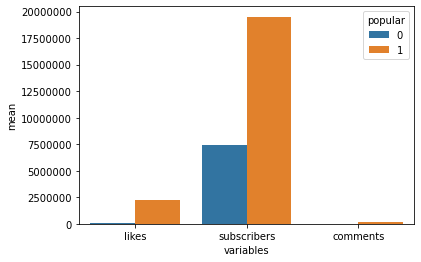

In [29]:
plt.ticklabel_format(style='plain')
sns.barplot(x='variables', y='mean', hue='popular', data=meandf) 


**Processing**

In [30]:
#spliting testing & training data
y = df['popular']
x = df.drop(['popular'], axis = 1)
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.1)


In [31]:
#standardisation 
scale = StandardScaler() 
xtrain = scale.fit_transform(xtrain)
xtest = scale.fit_transform(xtest)


**Support Vector Machine**

In [32]:
svm = SVC( )
svmpar = {'C':[0.001, 0.01, 0.1, 1,10],
          'gamma':[0.001, 0.01, 0.1, 1, 10],
          'kernel':['linear','rbf','sigmoid','poly']}

svmgridsearch = GridSearchCV ( svm , svmpar, n_jobs = -1 , cv = 10 )
svmgridsearch.fit(xtrain, ytrain)
print( "Best parameter: " + str (svmgridsearch.best_params_))
print( "Average accuracy of Cross Validation: "+ 
      str(svmgridsearch.best_score_))

Best parameter: {'C': 10, 'gamma': 10, 'kernel': 'poly'}
Average accuracy of Cross Validation: 0.9016772151898733


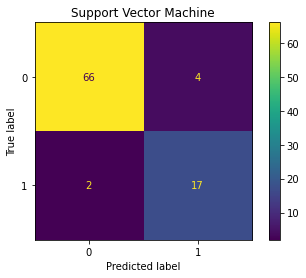

              precision    recall  f1-score   support

           0       0.97      0.94      0.96        70
           1       0.81      0.89      0.85        19

    accuracy                           0.93        89
   macro avg       0.89      0.92      0.90        89
weighted avg       0.94      0.93      0.93        89



In [33]:
svmmodel = SVC(C = svmgridsearch.best_params_['C'],
               gamma = svmgridsearch.best_params_['gamma'],
               kernel = svmgridsearch.best_params_['kernel'])

svmmodel.fit(xtrain, ytrain)

svmpredict = svmmodel.predict(xtest)
plot_confusion_matrix(svmmodel, xtest, ytest)
plt.title('Support Vector Machine')
plt.show()
print(classification_report(ytest, svmpredict))

AUC Score: 0.9187969924812031


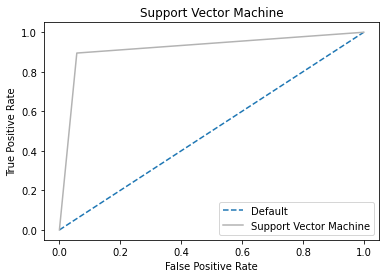

In [34]:
guess = [ 0 for _ in range (len(ytest))]
guessfpr, guesstpr, _ = roc_curve(ytest ,guess)

print('AUC Score:', roc_auc_score(ytest, svmpredict))
svmfpr, svmtpr, _ = roc_curve(ytest, svmpredict)
plt.plot(guessfpr, guesstpr, linestyle = '--', label = 'Default')
plt.plot(svmfpr, svmtpr, c = '.7', label = 'Support Vector Machine')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend() 
plt.title('Support Vector Machine')
plt.show() 

**Random Forest**

In [35]:
rfc = RandomForestClassifier() 
rfcpar = {'n_estimators':[100,500],
         'max_features': ['auto', 'sqrt', 'log2'],
         'max_depth': [5,10],
         'criterion':['gini','entropy']}

rfcgridsearch = GridSearchCV(rfc, rfcpar, cv = 10)
rfcgridsearch.fit(xtrain, ytrain)
print('Best parameters:'+ str(rfcgridsearch.best_params_))
print('Average Accuracy of Cross Validation:'+ str(rfcgridsearch.best_score_))

Best parameters:{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
Average Accuracy of Cross Validation:0.928243670886076


[[67  3]
 [ 2 17]]
              precision    recall  f1-score   support

           0       0.97      0.96      0.96        70
           1       0.85      0.89      0.87        19

    accuracy                           0.94        89
   macro avg       0.91      0.93      0.92        89
weighted avg       0.95      0.94      0.94        89



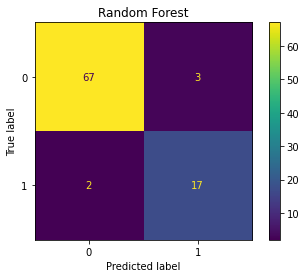

In [36]:
rfmodel = RandomForestClassifier(criterion = rfcgridsearch.best_params_['criterion'],
                                max_features = rfcgridsearch.best_params_['max_features'],
                                n_estimators = rfcgridsearch.best_params_['n_estimators'],
                                max_depth = rfcgridsearch.best_params_['max_depth'])

rfmodel = rfmodel.fit(xtrain, ytrain)
rfpred = rfmodel.predict(xtest)
print(confusion_matrix(ytest, rfpred))
plot_confusion_matrix(rfmodel, xtest, ytest)
plt.title('Random Forest')
print(classification_report(ytest, rfpred))
plt.show()

AUC Score: 0.9259398496240603


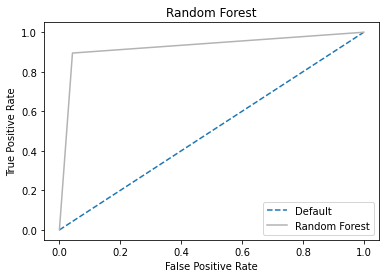

In [37]:
print('AUC Score:', roc_auc_score(ytest, rfpred))

rffpr, rftpr, _ = roc_curve(ytest, rfpred)
plt.plot(guessfpr, guesstpr, linestyle = '--', label = 'Default')
plt.plot(rffpr, rftpr, c = '.7', label = 'Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend() 
plt.title('Random Forest')
plt.show() 

Text(0.5, 0, 'Random Forest Feature Importance')

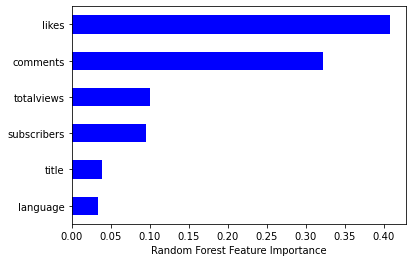

In [38]:
rf_feature_importances = pd.Series(rfmodel.feature_importances_,
                                index = df.drop(columns = ['popular'], axis =1).columns)
rf_feature_importances.nlargest(10).sort_values().plot(kind = 'barh',
                                                   color = 'blue')
plt.xlabel('Random Forest Feature Importance')


In [39]:
rfmodel.feature_importances_

array([0.03878273, 0.09526042, 0.10102669, 0.40879804, 0.03364027,
       0.32249186])

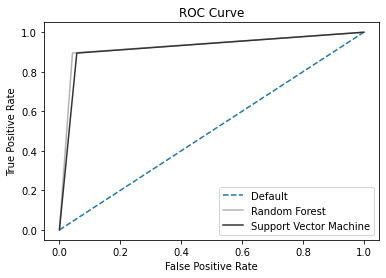

In [40]:
plt.plot(guessfpr, guesstpr, linestyle = '--', label = 'Default')
plt.plot(rffpr, rftpr, c = '.7', label = 'Random Forest')
plt.plot(svmfpr, svmtpr, c = '.2', label = 'Support Vector Machine')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend() 
plt.title('ROC Curve')
plt.show() 